# Satellite navigation disturbances in Finland

In [3]:
%pip install lxml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 43.2 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


required on Codespaces for pd.read_html()

In [13]:
import pandas as pd

In [16]:
url='situational-picture-disturbances-satellite-navigation-finland-2024'
(pd
 .read_html('https://www.traficom.fi/en/news/'+url)
 [0]
 .to_csv('finland_disturbance.csv',index=False)
)

Save data locally to avoid webscraping everytime I rerun the notebook.

In [17]:
fi_data=pd.read_csv('finland_disturbance.csv',header=1)

In [18]:
fi_data

,Year,Finland,Finnish operators’ notifications outside of Finland
0,2018,0,6
1,2019,8,137
2,2020,27,34
3,2021,8,71
4,2022,65,1331
5,2023,239,7370
6,2024 (by 30 April),Around 1200,Around 2100


Unfortunately the last line is not purely numeric and needs some cleanup.

array([<Axes: xlabel='disturbance_year'>,
       <Axes: xlabel='disturbance_year'>], dtype=object)

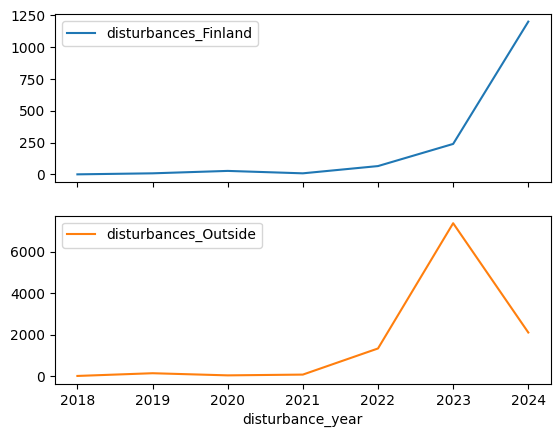

In [23]:
(fi_data
 .assign(
     disturbance_year=fi_data
     .Year
     .str.split(' ',expand=True)[0],
     disturbances_Finland=fi_data
     .Finland.str.replace('Around ','').astype('int32'),
     disturbances_Outside=fi_data
     ['Finnish operators’ notifications outside of Finland']
     .str.replace('Around ','').astype('int32')
 )
 .set_index('disturbance_year')
 .plot(subplots=True)
)